# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

C:\Users\rites\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
sent_0 = soup.get_text()
print(sent_0)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
sent_1000 = soup.get_text()
print(sent_1000)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
sent_1500 = soup.get_text()
print(sent_1500)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
sent_4900 = soup.get_text()
print(sent_4900)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"wont","will not",phrase) # in some words aposthepe is missing
    phrase = re.sub(r"its","it is",phrase)
    phrase = re.sub(r"Its","It is",phrase)
    phrase = re.sub(r"isnt","is not",phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)

My dogs loves this chicken but it is a product from China, so we will not be buying it anymore.  It is very hard to find any chicken products made in the USA but they are out there, but this one is not.  It is too bad too because it is a good product but I will not take any chances till they know what is going on with the china imports.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_4900 = re.sub("\S*\d\S*", "", sent_4900).strip()
print(sent_4900)

My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a  pound bag on Amazon for almost the same price as a  ounce bag at other retailers. It's definitely worth it to buy a big bag if your dog eats them a lot.


In [20]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

My dog LOVES these treats They tend to have a very strong fish oil smell So if you are afraid of the fishy smell don t get it But I think my dog likes it because of the smell These treats are really small in size They are great for training You can give your dog several of these without worrying about him over eating Amazon s price was much more reasonable than any other retailer You can buy a pound bag on Amazon for almost the same price as a ounce bag at other retailers It s definitely worth it to buy a big bag if your dog eats them a lot 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
import itertools
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    
    #https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
    # This removes words such as aawwww or happpyyy or awsooommmee etc
    sentence = ''.join(''.join(s)[:2] for _, s in itertools.groupby(sentence))
    
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:07<00:00, 1301.29it/s]


In [23]:
smpl = " aaaaww aaaww aaa aawwww"
sent = ''.join(''.join(s)[:2] for _, s in itertools.groupby(smpl))
print(sent)

 aaww aaww aa aaww


In [24]:
preprocessed_reviews[4900]

'dog loves treats tend strong fish oil smell afraid fishy smell not get think dog likes smell treats really small size great training give dog several without worrying eating amazon price much reasonable retailer buy pound bag amazon almost price ounce bag retailers definitely worth buy big bag dog eats lot'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly performing preprocessing for review summary also.

preprocessed_summary=[]

for sent in tqdm(final['Summary'].values):
    sent = re.sub(r"http\S+","",sent)
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = decontracted(sent)
    sent = re.sub(r"\S+\d\S+","",sent).strip()
    sent = re.sub(r"[^A-Za-z0]+"," ",sent)
    
    #https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
    # This removes words such as aawwww or happpyyy or awsooommmee etc
    sent = ''.join(''.join(s)[:2] for _, s in itertools.groupby(sent))
    
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(w.lower() for w in sent.split() if w.lower() not in stopwords)
    preprocessed_summary.append(sent.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:34<00:00, 2512.46it/s]


In [26]:
preprocessed_summary[4900]

'great value'

In [27]:
final['Summary'].values[4900]

'Great value'

In [28]:
# Removing those words which are of lenght 2
# This will remove non relevant words then we will perform featurization
cleaned_reviews = []
for sent in preprocessed_reviews:
    sentence = ' '.join(w for w in sent.split() if len(w)>2)
    cleaned_reviews.append(sentence.strip())

In [29]:
print(cleaned_reviews[0])

dogs loves chicken product china not buying anymore hard find chicken products made usa one not bad good product not take chances till know going china imports


In [30]:
final["Cleaned_review"] = cleaned_reviews
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_review
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china not buying an...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


# [4] Featurization

## [4.1] BAG OF WORDS

In [36]:
#BoW
count_vect1 = CountVectorizer() #in scikit-learn
count_vect1.fit(cleaned_reviews)
print("some feature names ", count_vect1.get_feature_names()[:10])
print('='*50)

final_counts = count_vect1.transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aaa', 'aaah', 'aaahh', 'aaaww', 'aachen', 'aadp', 'aaf', 'aafco', 'aah', 'aahhs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54095)
the number of unique words  54095


## [4.2] Bi-Grams and n-Grams.

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numbers min_df=10, max_features=5000, of your choice
count_vect2 = CountVectorizer(ngram_range=(1,2), min_df=5)
final_bigram_counts = count_vect2.fit_transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
bigram_features = count_vect2.get_feature_names()
print(bigram_features[:10])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 112780)
the number of unique words including both unigrams and bigrams  112780
['aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal pain', 'abide', 'abilities']


## [4.3] TF-IDF

In [38]:
# tfidf on unigrams
tf_idf_vect1 = TfidfVectorizer()
tf_idf_vect1.fit(cleaned_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect1.get_feature_names()[0:10])
print('='*50)

final_tf_idf1 = tf_idf_vect1.transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_tf_idf1))
print("the shape of out text TFIDF vectorizer ",final_tf_idf1.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf1.get_shape()[1])

some sample features(unique words in the corpus) ['aaa', 'aaah', 'aaahh', 'aaaww', 'aachen', 'aadp', 'aaf', 'aafco', 'aah', 'aahhs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 54095)
the number of unique words including both unigrams and bigrams  54095


In [39]:
# Tfidf on bigrams
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2),min_df=3)
tf_idf_vect2.fit(cleaned_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect2.get_feature_names()[0:10])
print('='*50)

final_tf_idf2 = tf_idf_vect2.transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_tf_idf2))
print("the shape of out text TFIDF vectorizer ",final_tf_idf2.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf2.get_shape()[1])

some sample features(unique words in the corpus) ['aafco', 'aafco dog', 'aah', 'aahs', 'aback', 'abandon', 'abandoned', 'abandoning', 'abbott', 'abbreviated']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 213055)
the number of unique words including both unigrams and bigrams  213055


## [4.4] Word2Vec

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in tqdm(cleaned_reviews):
    list_of_sentence.append(sentence.split())

100%|████████████████████████████████████████████████████████████████████████| 87773/87773 [00:00<00:00, 107758.27it/s]


In [32]:
outfile = open("list_of_sentence","wb")
pickle.dump(list_of_sentence,outfile)
outfile.close()

In [41]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb 
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v =False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8564410209655762), ('good', 0.8339499235153198), ('terrific', 0.8293559551239014), ('awesome', 0.8228894472122192), ('excellent', 0.8163968324661255), ('wonderful', 0.767386257648468), ('perfect', 0.7606471180915833), ('nice', 0.7306604981422424), ('amazing', 0.7093859910964966), ('decent', 0.708103597164154)]
[('greatest', 0.8057908415794373), ('tastiest', 0.7508324384689331), ('best', 0.7100083827972412), ('weakest', 0.653785765171051), ('nastiest', 0.6437786817550659), ('surpass', 0.6423906087875366), ('coolest', 0.6342161893844604), ('disgusting', 0.6276921033859253), ('hottest', 0.6255906820297241), ('closest', 0.6034766435623169)]


In [42]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17061
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'not', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate', 'day']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

KeyboardInterrupt: 

#### [4.4.1.2] TFIDF weighted W2v

In [43]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(cleaned_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

KeyboardInterrupt: 

In [45]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

64957
50


In [46]:
# Function to plot confusion matrix
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Original No","Original Yes"]
    
    cmap=sns.light_palette("orange")
    print("Confusion matrix")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.show()

In [47]:
# Function to plot roc curve

def plot_roc_curve(Y_test,predict_y_test,Y_train,predict_y_train):
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Validation AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()
    plt.show()

In [48]:
# Plotting graph of auc and parameter for training and cross validation error
param = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]

def plot_knn_vs_auc(train_auc_list,cv_auc_list):
    plt.plot(param,train_auc_list,label="Train AUC")
    plt.xlabel("Parameter for K-NN")
    plt.ylabel("Area Under Curve")
    plt.plot(param,cv_auc_list,label="Validation AUC")
    plt.legend()
    plt.show()

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [49]:
from sklearn.cross_validation import train_test_split

# cleaned_reviews contains all the required reviews
# Splitting cleaned_reviews into train and test dataset

X = cleaned_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(Y_train),len(X_test),len(Y_test))

61441 61441 26332 26332


In [50]:
# Now we will vectorize train and test datasets separately using BagofWords
# Use fit_transform to vectorize train dataset and transform to vectorize test dataset
count_vect2 = CountVectorizer(max_features=2000)
X_train = count_vect2.fit_transform(X_train)
X_test = count_vect2.transform(X_test)
print(X_train.shape,X_test.shape)

(61441, 2000) (26332, 2000)


In [52]:
# In this section we will calculate training error.
# To calculate training error you have to train model using training data and 
# Then test the same model on trainig data and compare the predicted labels with actual labels
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = X_train[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = X_train[20000:40000][:]
x_train_3 = X_train[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute",leaf_size=30)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute",leaf_size=30)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute",leaf_size=30)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:35<00:00, 25.38s/it]


In [53]:
# Combining training result of each batch together
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]

In [54]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required


# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

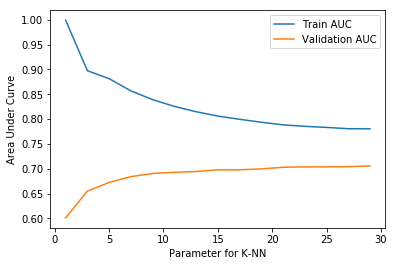

In [55]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,cv_auc_list)

<h4> Observing the graph we will select a k for which AUC is not very high in training error plot to avoid overfitting 
and select a k for which AUC is not very low in Cross-validation error to avoid underfitting.
Therefore we are selecting k = 25 . </h4>

In [56]:
# Training final model on best auc and taking k = 25

# Training one model with all the data hangs the PC . 
# Therefore we will divide data into 3 parts and then train three seperate models.
final_clf1 = KNeighborsClassifier(n_neighbors=25,algorithm='brute',leaf_size=30)
final_clf1.fit(x_train_1,y_train_1)
predict_probab_1 = final_clf1.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y1 = final_clf1.predict(X_test) 
predict_y_train1 = final_clf1.predict(x_train_1)

final_clf2 = KNeighborsClassifier(n_neighbors=25,algorithm='brute',leaf_size=30)
final_clf2.fit(x_train_2,y_train_2)
predict_probab_2 = final_clf2.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y2 = final_clf2.predict(X_test) 
predict_y_train2 = final_clf2.predict(x_train_2)

final_clf3 = KNeighborsClassifier(n_neighbors=25,algorithm='brute',leaf_size=30)
final_clf3.fit(x_train_3,y_train_3)
predict_probab_3 = final_clf3.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y3 = final_clf3.predict(X_test) 
predict_y_train3 = final_clf3.predict(x_train_3)

# Now merging,n_jobs=3 all the three probability scores into one 

predict_probab = [(x+y+z)/3 for x,y,z in zip(predict_probab_1,predict_probab_2,predict_probab_3)]



auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC is ::{:.2f}".format(auc))


Final AUC is ::0.73


In [57]:
# combining labels predicted by all the models
predict_y = [1 if (x+y+z)>= 2 else 0 for x,y,z in zip(predict_y1,predict_y2,predict_y3)]

In [58]:
# Combining results of train dataset evaluation
predict_y_train = np.concatenate((predict_y_train1,predict_y_train2),axis=None)
predict_y_train = np.concatenate((predict_y_train,predict_y_train3),axis=None)

Confusion matrix


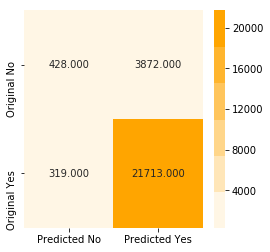

In [59]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

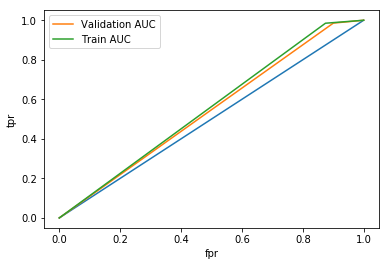

In [60]:
# Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.1.2] Applying KNN brute force on TFIDF

In [99]:
# In this section Tfidf will be used for vectorization
# Splitting datasets into train and test datasets

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# Initializinf TFidf
tf_idf_vect2 = TfidfVectorizer(max_features=2000)
# Now we will vectorize train and test datasets separately using Tfidf 
# Use fit_transform to vectorize train dataset and transform to vectorize test dataset
X_train = tf_idf_vect2.fit_transform(X_train)
X_test = tf_idf_vect2.transform(X_test)

In [100]:
param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = X_train[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = X_train[20000:40000][:]
x_train_3 = X_train[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in range(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute",leaf_size=30)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in range(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute",leaf_size=30)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in range(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute",leaf_size=30)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)
    
# Combining training result of each batch together
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]

In [101]:
# Performing time series split cross validation

auc_list=[]

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30,n_jobs=3)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
    
    
    auc_list.append(auc/i)

        

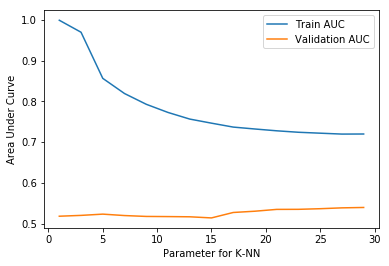

In [102]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list)

In [103]:
# Training final model on best auc and taking k = 21

# Training one model with all the data hangs the PC . 
# Therefore we will divide data into 3 parts and then train three seperate models.
final_clf1 = KNeighborsClassifier(n_neighbors=21,algorithm='brute',leaf_size=30)
final_clf1.fit(x_train_1,y_train_1)
predict_probab_1 = final_clf1.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y1 = final_clf1.predict(X_test)
predict_y_train1 = final_clf1.predict(x_train_1)

final_clf2 = KNeighborsClassifier(n_neighbors=21,algorithm='brute',leaf_size=30)
final_clf2.fit(x_train_2,y_train_2)
predict_probab_2 = final_clf2.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y2 = final_clf2.predict(X_test)
predict_y_train2 = final_clf2.predict(x_train_2)

final_clf3 = KNeighborsClassifier(n_neighbors=21,algorithm='brute',leaf_size=30)
final_clf3.fit(x_train_3,y_train_3)
predict_probab_3 = final_clf3.predict_proba(X_test)[:,1] # This returns only probability of +ve class
predict_y3 = final_clf3.predict(X_test)
predict_y_train3 = final_clf3.predict(x_train_3)

# Now merging all the three probability scores into one 
predict_probab = [(x+y+z)/3 for x,y,z in zip(predict_probab_1,predict_probab_2,predict_probab_3)]
predict_y = [1 if(x+y+x>= 2) else 0 for x,y,z in zip(predict_y1,predict_y2,predict_y3)]

# Combining results of train dataset evaluation
predict_y_train = np.concatenate((predict_y_train1,predict_y_train2),axis=None)
predict_y_train = np.concatenate((predict_y_train,predict_y_train3),axis=None)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC is ::{:.2f}".format(auc))

Final AUC is ::0.51


Confusion matrix


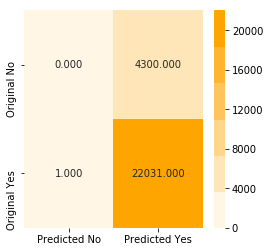

In [104]:
# plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

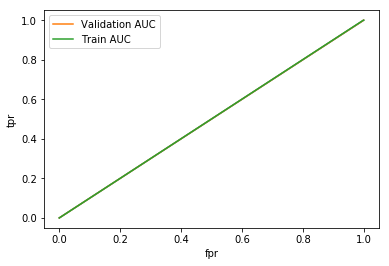

In [105]:
# Plotting roc curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [106]:
# In this section avg_w2v will be used for vectorization
# Splitting datasets into train and test datasets
Y = final['Score']
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentence,Y,test_size=0.3,random_state=42)
print(X_train[0])


['use', 'beans', 'espresso', 'machine', 'love', 'taste', 'straight', 'espresso', 'coffee', 'find', 'much', 'caffeine', 'stresses', 'coffee', 'tastes', 'great', 'espresso', 'subscribe', 'coffee', 'amazon', 'receive', 'order', 'month', 'discount', 'free', 'shipping', 'good', 'deal']


In [107]:
# Now we will vectorize train dataset usin avg_w2v
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

61441
50


In [108]:
# Vectorization of test dataset using avg_w2v

test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

26332
50


In [109]:
param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = train_sent_vectors[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = train_sent_vectors[20000:40000][:]
x_train_3 = train_sent_vectors[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:19<00:00, 14.13s/it]


In [110]:
# Combining training result of each batch together
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]

In [111]:
# 10 fold cross validation using time series splitting
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
auc_list=[]

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
    auc_list.append(auc/i)

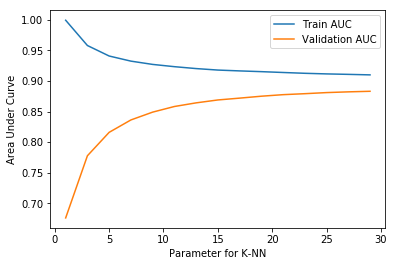

In [113]:
# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list)

In [115]:
# Training final model on best auc and taking k = 25

# Training one model with all the data hangs the PC . 
# Therefore we will divide data into 3 parts and then train three seperate models.
final_clf1 = KNeighborsClassifier(n_neighbors=30,algorithm='brute',leaf_size=40)
final_clf1.fit(x_train_1,y_train_1)
predict_probab_1 = final_clf1.predict_proba(test_sent_vectors)[:,1] # This returns only probability of +ve class 
predict_y1 = final_clf1.predict(test_sent_vectors)
predict_y_train1 = final_clf1.predict(x_train_1)

final_clf2 = KNeighborsClassifier(n_neighbors=30,algorithm='brute',leaf_size=40)
final_clf2.fit(x_train_2,y_train_2)
predict_probab_2 = final_clf2.predict_proba(test_sent_vectors)[:,1] # This returns only probability of +ve class 
predict_y2 = final_clf2.predict(test_sent_vectors)
predict_y_train2 = final_clf2.predict(x_train_2)

final_clf3 = KNeighborsClassifier(n_neighbors=30,algorithm='brute',leaf_size=40)
final_clf3.fit(x_train_3,y_train_3)
predict_probab_3 = final_clf3.predict_proba(test_sent_vectors)[:,1] # This returns only probability of +ve class
predict_y3 = final_clf3.predict(test_sent_vectors)
predict_y_train3 = final_clf3.predict(x_train_3)

# Now merging all the three probability scores into one 
predict_probab = [(x+y+z)/3 for x,y,z in zip(predict_probab_1,predict_probab_2,predict_probab_3)]
predict_y = [1 if(x+y+x>= 2) else 0 for x,y,z in zip(predict_y1,predict_y2,predict_y3)]

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC is ::{:.2f}".format(auc))

Final AUC is ::0.90


In [116]:
predict_y_train = [] # will store predicted class labels of combined predicted labels

# Combining predicted labels of train dataset evaluation
# Appending predicted labels of first model
for i in predict_y_train1:
    predict_y_train.append(i)

# Appending predicted labels of second model
for i in predict_y_train2:
    predict_y_train.append(i)
    
# Appending predicted labels of third model
for i in predict_y_train3:
    predict_y_train.append(i)

print(len(predict_y_train))

61441


Confusion matrix


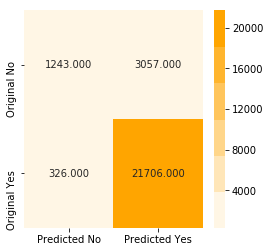

In [117]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

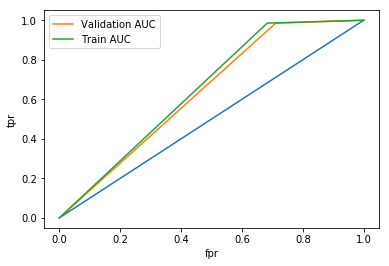

In [118]:
# Plotting roc 
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.1.4] Applying KNN brute force on TFIDF W2V

In [103]:
Y = final['Score'] # Contains labels of data points
X_train,X_test,Y_train,Y_test = train_test_split(cleaned_reviews,Y,test_size=0.3,random_state=42)

In [104]:
# Vectorizing train dataset using tfidf
model = TfidfVectorizer()
model.fit_transform(X_train)
tfidf_feat1 = model.get_feature_names()

# This will map word with their tfidf only for train dataset
dictionary1 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [105]:
# Vectorizing test dataset using tfidf
model.transform(X_test)
tfidf_feat2 = model.get_feature_names()

# This will map word with their tfidf only for test dataset
dictionary2 = dict(zip(model.get_feature_names(), list(model.idf_)))

In [106]:
# Vectorizing train dataset

# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in X_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat1:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)


In [107]:
# TF-IDF weighted Word2Vec
# Vectorizing test dataset. 

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in X_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat2:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum +=1
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)

In [108]:
# Calculating training error .
# Because of large amount of data. we are processing data into three batches here.
# After processing all the results of these batches are merged into one .

train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = train_tfidf_sent_vectors[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = train_tfidf_sent_vectors[20000:40000][:]
x_train_3 = train_tfidf_sent_vectors[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=30,n_jobs=3)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=30,n_jobs=3)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=30,n_jobs=3)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)
    
# Combining results together.
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:35<00:00, 26.48s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:58<00:00, 23.11s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:24<00:00, 25.64s/it]


In [109]:
# 10 fold cross validation using time series splitting

auc_list = []

for k in tqdm(range(1,30,2)):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=30,n_jobs=3)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # Returns probability of for positive class only.
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
    
    auc_list.append(auc/i) # Averaging auc for all 10 folds .


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [44:01<00:00, 176.22s/it]


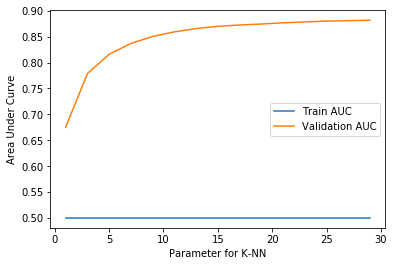

In [110]:
# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list)

In [111]:
30# Training final model on best auc and taking k = 10

# Training one model with all the data hangs the PC . 
# Therefore we will divide data into 3 parts and then train three seperate models.
x_train_1 = train_tfidf_sent_vectors[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = train_tfidf_sent_vectors[20000:40000][:]
x_train_3 = train_tfidf_sent_vectors[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]


final_clf1 = KNeighborsClassifier(n_neighbors=30,algorithm='kd_tree',leaf_size=40,n_jobs=3)
final_clf1.fit(x_train_1,y_train_1)
predict_probab_1 = final_clf1.predict_proba(test_tfidf_sent_vectors)[:,1] # This returns only probability of +ve class 
predict_y_train1 = list(final_clf1.predict(x_train_1))

final_clf2 = KNeighborsClassifier(n_neighbors=30,algorithm='kd_tree',leaf_size=40,n_jobs=3)
final_clf2.fit(x_train_2,y_train_2)
predict_probab_2 = final_clf2.predict_proba(test_tfidf_sent_vectors)[:,1] # This returns only probability of +ve class 
predict_y_train2 = list(final_clf1.predict(x_train_2))

final_clf3 = KNeighborsClassifier(n_neighbors=30,algorithm='kd_tree',leaf_size=40,n_jobs=3)
final_clf3.fit(x_train_3,y_train_3)
predict_probab_3 = final_clf3.predict_proba(test_tfidf_sent_vectors)[:,1] # This returns only probability of +ve class 
predict_y_train3 = final_clf1.predict(x_train_3)

# Now merging all the three probability scores into one 

predict_probab = [(x+y+z)/3 for x,y,z in zip(predict_probab_1,predict_probab_2,predict_probab_3)]
predict_y = [1 if(x+y+z>=2) else 0 for x,y,z in zip(predict_probab_1,predict_probab_2,predict_probab_3) ]

# Combining results for train dataset
predict_y_train = np.concatenate((predict_y_train1,predict_y_train2),axis=None)
predict_y_train = np.concatenate((predict_y_train,predict_y_train3),axis=None)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC is ::{:.2f}".format(auc))

Final AUC is ::0.50


Confusion matrix


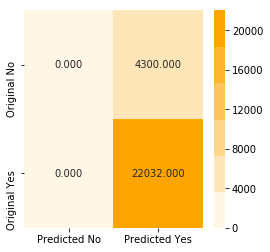

In [112]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

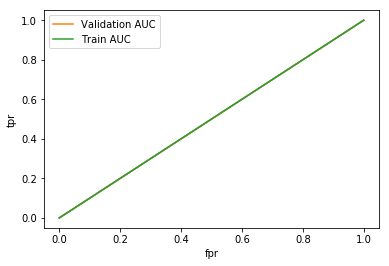

In [113]:
# Plotting roc curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [61]:
# Kd tree works slow for high dimensional data.
# Therefore taking top 5000 features
from sklearn.cross_validation import train_test_split
count_vect = CountVectorizer(max_features=5000)

X = cleaned_reviews
Y = final["Score"]
# Splitting data into train and test dataset
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(X_test))

61441 26332


In [62]:
# Vectorizing train and test dataset seperately
X_train = count_vect.fit_transform(X_train)
print(X_train.shape)

X_test = count_vect.transform(X_test)
print(X_test.shape)

(61441, 5000)
(26332, 5000)


In [63]:
# Since kd Tree dont take sparse matrix .
# Therefore we are converting sparse to dense matrxi using TruncatedSVD
from sklearn.decomposition import TruncatedSVD

# Initializing TruncatedSVD
# Too many features takes a lot of time . Therefore taking 500 features only
svd = TruncatedSVD(n_components=200,algorithm='randomized',n_iter=50,random_state=42)
X_train = svd.fit_transform(X_train)
X_test = svd.fit_transform(X_test)
print(X_train.shape,X_test.shape)

(61441, 200) (26332, 200)


In [66]:
# Calculating training error .
# Because of large amount of data. we are processing data into three batches here.
# After processing all the results of these batches are merged into one .

param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for stqdm(econd batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = X_train[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = X_train[20000:40000][:]
x_train_3 = X_train[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:02:25<00:00, 273.88s/it]


In [67]:
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]

In [68]:
# Performing 10 fold cross validation on time split data

tscv = TimeSeriesSplit(n_splits=10)
auc_list1 = []

for k in range(1,30,2):
    clf1 = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40)
    auc1 = 0.0
    i1=0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf1.fit(x_train,y_train)
    
        predict_probab1 = clf1.predict_proba(x_test)[:,1]
        i1 += 1
        auc1 += roc_auc_score(y_test,predict_probab1)
    
    auc_list1.append(auc1/i1)
    

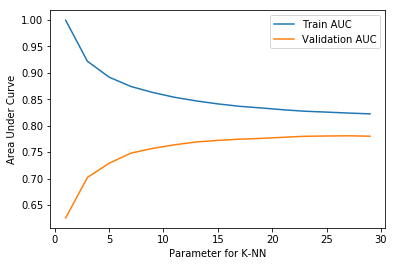

In [70]:
# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list1)

In [75]:
# Training final model on best auc and taking k = 25

final_clf = KNeighborsClassifier(n_neighbors=25,algorithm='kd_tree',leaf_size=40)
final_clf.fit(X_train,Y_train)
predict_probab = final_clf.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y = final_clf.predict(X_test)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC is ::{:.2f}".format(auc))

Final AUC is ::0.63


In [72]:
predict_y_train = final_clf.predict(X_train)

Confusion matrix


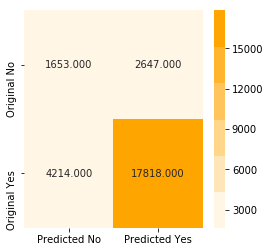

In [76]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

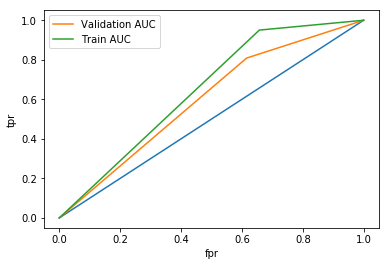

In [77]:
# Plotting roc curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [78]:
# In this section Tfidf will be used for vectorization
# Splitting datasets into train and test datasets

X = final['Cleaned_review']
Y = final['Score']
tf_idf_vect = TfidfVectorizer(max_features=300)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# Now we will vectorize train and test datasets separately using Tfidf 
# Use fit_transform to vectorize train dataset and transform to vectorize test dataset
X_train = tf_idf_vect.fit_transform(X_train)
X_test = tf_idf_vect.transform(X_test)

In [79]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200,algorithm='randomized',n_iter=50,random_state=42)
X_train = svd.fit_transform(X_train)
X_test = svd.fit_transform(X_test)
print(X_train.shape,X_test.shape)

(61441, 200) (26332, 200)


In [80]:
param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = X_train[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = X_train[20000:40000][:]
x_train_3 = X_train[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40,n_jobs=3)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40,n_jobs=3)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40,n_jobs=3)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [27:46<00:00, 117.68s/it]


In [81]:
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]

In [84]:
# Performing 10 fold cross validation on time split data

tscv = TimeSeriesSplit(n_splits=10)
auc_list1 = []

for k in tqdm(range(1,30,2)):
    clf1 = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40,n_jobs=3)
    auc1 = 0.0
    i1=0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf1.fit(x_train,y_train)
    
        predict_probab1 = clf1.predict_proba(x_test)[:,1]
        i1 += 1
        auc1 += roc_auc_score(y_test,predict_probab1)
    
    auc_list1.append(auc1/i1)
    
        


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:52:53<00:00, 455.96s/it]


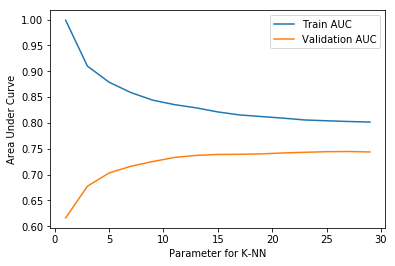

In [85]:
# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list1)

In [86]:
# Training final model on best auc and taking k = 11

final_clf = KNeighborsClassifier(n_neighbors=24,algorithm='kd_tree',leaf_size=30,n_jobs=3)

final_clf.fit(X_train,Y_train)

predict_probab = final_clf.predict_proba(X_test)[:,1] # This returns only probability of +ve class 
predict_y = final_clf.predict(X_test)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC is {:.2f}".format(auc))


Final AUC is 0.57


In [89]:
predict_y_train = final_clf.predict(X_train)

Confusion matrix


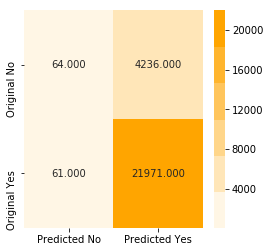

In [87]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

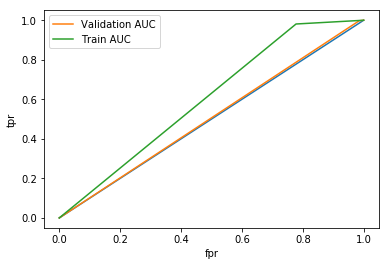

In [90]:
# Plotting roc curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [91]:
# Splitting data into train and test.
Y = final['Score']
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentence,Y,test_size=0.3,random_state=42)

In [92]:
# Now we will vectorize train dataset usin avg_w2v
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

61441
50


In [93]:
# Vectorization of test dataset using avg_w2v

test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

26332
50


In [94]:
param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = train_sent_vectors[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = train_sent_vectors[20000:40000][:]
x_train_3 = train_sent_vectors[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=30,n_jobs=3)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=30,n_jobs=3)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=30,n_jobs=3)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)

# Combining the result into one. 
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [09:50<00:00, 45.65s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:36<00:00, 50.08s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [13:05<00:00, 56.76s/it]


In [95]:
# 10 fold cross validation using time series splitting
# Here X_train is train_sent_vectors and X_test is test_sent_vectors
# Here vectorization results of previous section is used . Only KNN algorithm is changed
tscv = TimeSeriesSplit(n_splits=10)
auc_list=[]
for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40,n_jobs=3)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        
        clf.fit(x_train,y_train)
        predict_probab = clf.predict_proba(x_test)[:,1]
        #print(len(x_test),len(y_test),len(predict_probab))
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
    
    auc_list.append(auc/i)

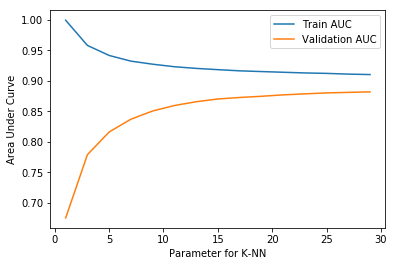

In [96]:
# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list)

In [97]:
# Training the final model
final_clf = KNeighborsClassifier(n_neighbors=25,algorithm='kd_tree',leaf_size=30,n_jobs=3)

final_clf.fit(train_sent_vectors,Y_train)

predict_probab = final_clf.predict_proba(test_sent_vectors)[:,1] # Returns the class probabality of +ve class only
predict_y = final_clf.predict(test_sent_vectors)
predict_y_train = final_clf.predict(train_sent_vectors)
auc = roc_auc_score(Y_test,predict_probab)

print("Final AUC is {:.2f}".format(auc))

Final AUC is 0.89


Confusion matrix


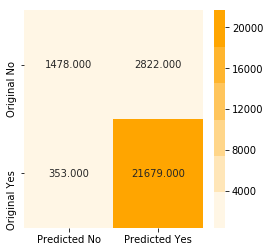

In [98]:
# Plotting confusion matrix
confusion_matrix_plot(Y_test,predict_y)

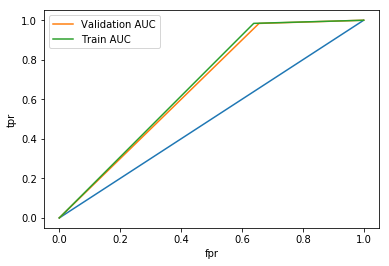

In [101]:
## Plotting roc curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [114]:
# Using vectorized data from previous section

# Calculating training error .
# Because of large amount of data. we are processing data into three batches here.
# After processing all the results of these batches are merged into one .

train_auc_list1 = []   # This contains area under curve value of first batch corresponding for each k
train_auc_list2 = []   # for second batch 
train_auc_list3 = []   # for third batch

# Testing whole training data at once takes a lot of memory which takes a lot of time .
# There fore we are dividing training data into 3 parts and then we will calculate AUC
    
x_train_1 = train_tfidf_sent_vectors[0:20000][:] # Row 0 to 19999 and all columns
x_train_2 = train_tfidf_sent_vectors[20000:40000][:]
x_train_3 = train_tfidf_sent_vectors[40000:61441][:]

y_train_1 = Y_train[0:20000][:] # Row 0 to 19999 and all columns
y_train_2 = Y_train[20000:40000][:]
y_train_3 = Y_train[40000:61441][:]

# Calculating training error for first batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40,n_jobs=3)
    clf.fit(x_train_1,y_train_1)

    pre_probab = clf.predict_proba(x_train_1)[:,1] # Returns probability of positive class
    
    auc = roc_auc_score(y_train_1,pre_probab)
    train_auc_list1.append(auc)

# Calculating training error for second batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40,n_jobs=3)
    clf.fit(x_train_2,y_train_2)

    pre_probab = clf.predict_proba(x_train_2)[:,1]
    
    auc = roc_auc_score(y_train_2,pre_probab)
    train_auc_list2.append(auc)
    

# Calculating training error for third batch
for k in tqdm(range(1,30,2)):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",leaf_size=40,n_jobs=3)
    clf.fit(x_train_3,y_train_3)

    pre_probab = clf.predict_proba(x_train_3)[:,1]
    
    auc = roc_auc_score(y_train_3,pre_probab)
    train_auc_list3.append(auc)
    
# Combining results together.
train_auc_list = [(x+y+z)/3 for x,y,z in zip(train_auc_list1,train_auc_list2,train_auc_list3)]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:10<00:00, 21.46s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:21<00:00, 21.28s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:50<00:00, 27.43s/it]


In [115]:
# 10 fold cross validation using time series splitting
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
auc_list = []

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40,n_jobs=3)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
        x_train = train_tfidf_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_tfidf_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # Returns probability of for positive class only.
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
    
    auc_list.append(auc/i) # Averaging auc for all 10 folds .

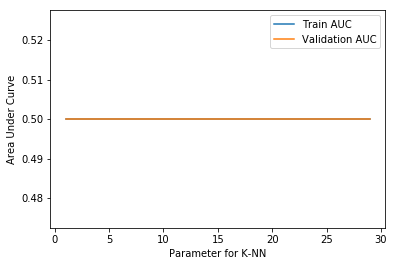

In [117]:
# Plotting graph of auc and parameter for training and cross validation error
plot_knn_vs_auc(train_auc_list,auc_list)

In [118]:
# Training the final model
final_clf = KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree',leaf_size=40,n_jobs=3)

final_clf.fit(train_tfidf_sent_vectors,Y_train)

predict_probab = final_clf.predict_proba(test_tfidf_sent_vectors)[:,1] # Returns the class probabality of +ve class only

auc = roc_auc_score(Y_test,predict_probab)

print("AUC of model is {:.2f}".format(auc))

AUC of model is 0.50


In [119]:
# Train and test prediction 
predict_y = final_clf.predict(test_tfidf_sent_vectors)
predict_y_train = final_clf.predict(train_tfidf_sent_vectors)


Confusion matrix


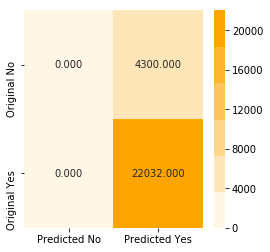

In [120]:
# Plotting confusion matrix , precision and recall matrix
confusion_matrix_plot(Y_test,predict_y)


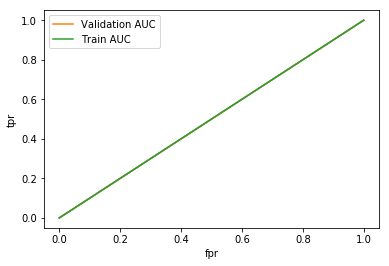

In [121]:
# Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

# [6] Conclusions

In [1]:
from prettytable import PrettyTable

x = PrettyTable()


x.field_names = ["Model Type","Best K","AUC",]

x.add_row(["BOW","21","0.67"])
x.add_row(["TfIdf","25","0.51"])
x.add_row(["Avg W2V","17","0.87"])
x.add_row(["TfIdf Weighted W2V","21","0.50"])
print(x)

+--------------------+--------+------+
|     Model Type     | Best K | AUC  |
+--------------------+--------+------+
|        BOW         |   21   | 0.67 |
|       TfIdf        |   25   | 0.51 |
|      Avg W2V       |   17   | 0.87 |
| TfIdf Weighted W2V |   21   | 0.50 |
+--------------------+--------+------+
